In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Path style access for pandas
!pip install pandas-path
from pandas_path import path

import rasterio

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import jaccard_score

In [2]:
def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        metadata = img.meta
        bounds = img.bounds
        data = img.read(1)  # read a single band

    with rasterio.open(image_path) as img:
        return img.read(1)

# Get the metadata dataframe

In [3]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent / "runtime" / "data" / "train_features"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

train_metadata = train_metadata.iloc[::2]
train_metadata.reset_index(inplace=True, drop=True)
train_metadata

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
2,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15
3,awc03_vh,awc03,awc,vh,Bolivia,2018-02-15
4,awc04_vh,awc04,awc,vh,Bolivia,2018-02-15
...,...,...,...,...,...,...
537,wvy27_vh,wvy27,wvy,vh,UK,2019-02-15
538,wvy28_vh,wvy28,wvy,vh,UK,2019-02-15
539,wvy29_vh,wvy29,wvy,vh,UK,2019-02-15
540,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15


In [4]:
PRED_PATH = Path.cwd().parent / "test submission" / "codeexecution"
train_metadata["pred_path"] = (
    str(PRED_PATH / "submission")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

# Calculate the jaccard score for every prediction

In [16]:
from pathlib import Path
from loguru import logger
import numpy as np
from tifffile import imread
import typer
from tqdm import tqdm

NA_VALUE = 255

In [17]:
def iterate_through_mask_pairs(submission_dir: Path, actual_dir: Path):
    """
    For each tif in the actual directory, find the corresponding prediction tif, read
    them both in, and yield the (pred, actual) tuple
    """
    for actual_path in actual_dir.glob("*.tif"):
        filename = actual_path.name
        predicted_path = submission_dir / filename
        assert predicted_path.exists(), f"Could not find expected file: {filename}"
        actual = imread(actual_path)
        pred = imread(predicted_path)
        yield pred, actual

In [18]:
def intersection_over_union(df, total=None):
    """Calculate the actual metric"""
    intersection = 0
    union = 0
    for pred, actual in tqdm(array_pairs, total=total):
        invalid_mask = actual == NA_VALUE
        actual = np.ma.masked_array(actual, invalid_mask)
        pred = np.ma.masked_array(pred, invalid_mask)
        intersection += np.logical_and(actual, pred).sum()
        union += np.logical_or(actual, pred).sum()
    if union < 1:
        raise ValueError("At least one image must be in the actual data set")
    return intersection / union

In [25]:
submission_dir = Path.cwd().parent / "test submission" / "codeexecution" / "submission"
actual_dir = Path.cwd().parent / "runtime" / "data" / "train_features" / "train_labels"

n_expected = len(list(actual_dir.glob("*.tif")))
array_pairs = iterate_through_mask_pairs(submission_dir, actual_dir)
logger.info(f"calculating score for {n_expected} image pairs ...")
score = intersection_over_union(array_pairs, total=n_expected)
logger.success(f"overall score: {score}")

2021-09-04 10:49:06.222 | INFO     | __main__:<module>:6 - calculating score for 542 image pairs ...
100%|██████████| 542/542 [00:08<00:00, 61.59it/s]
2021-09-04 10:49:15.022 | SUCCESS  | __main__:<module>:8 - overall score: 0.6101878959839172


# Display the label and prediction

In [14]:
def display(df, id_): 
    pred = numpy_mask(df['pred_path'][id_])
    label = numpy_mask(df['label_path'][id_])
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(pred, "gray")
    ax[0].set_title("prediction")
    ax[1].imshow(label, "gray")
    ax[1].set_title("label")
    plt.show()

jaccard score 1.0


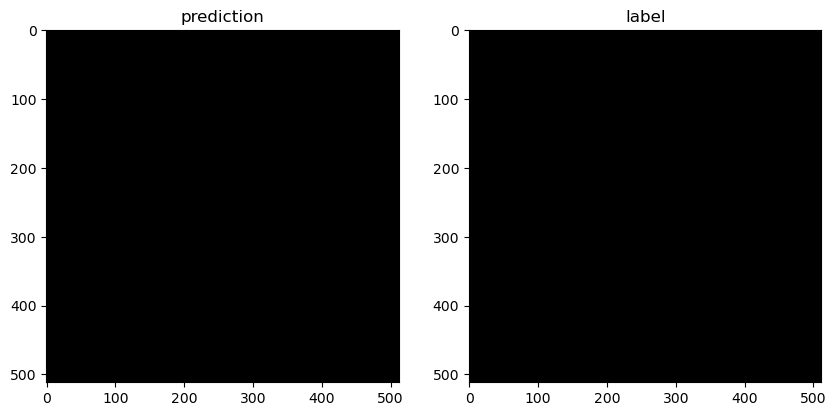

In [15]:
id_ = 5
#print("jaccard score", result[id_])
display(train_metadata, id_)

[532, 540, 513, 525, 530, 538, 524, 517, 512, 521, 533, 535, 523, 518, 527, 539, 531, 427, 372, 376, 537, 442, 541, 120, 536, 426, 522, 370, 201, 31]
jaccard score 1.0


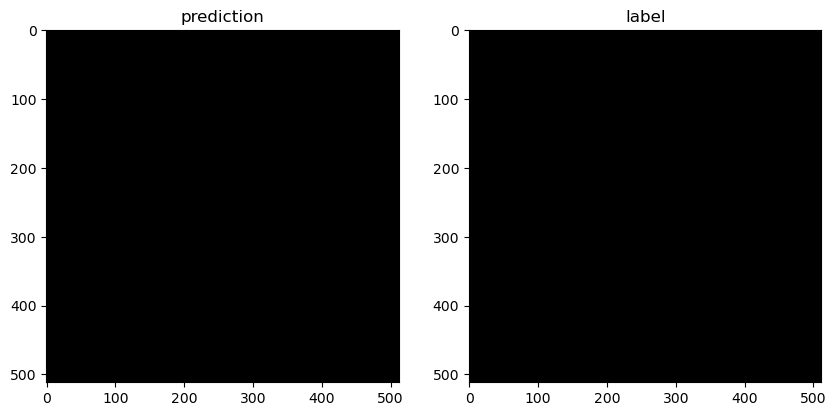

jaccard score 1.0


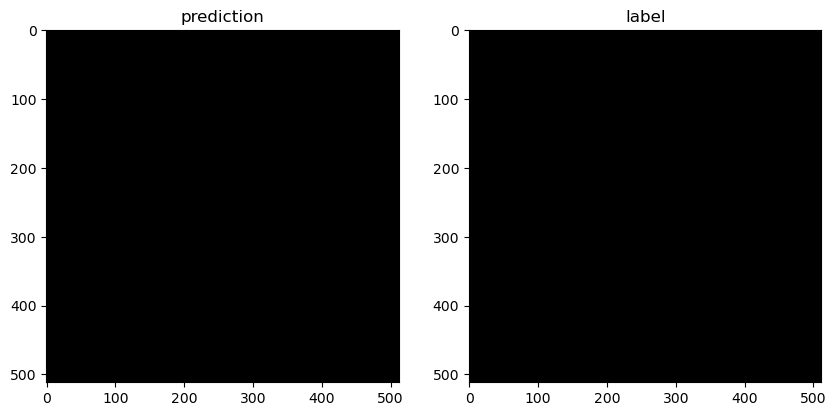

jaccard score 1.0


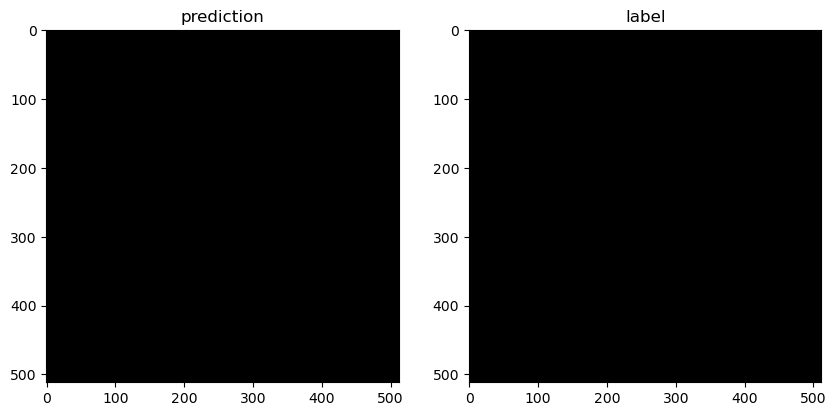

jaccard score 1.0


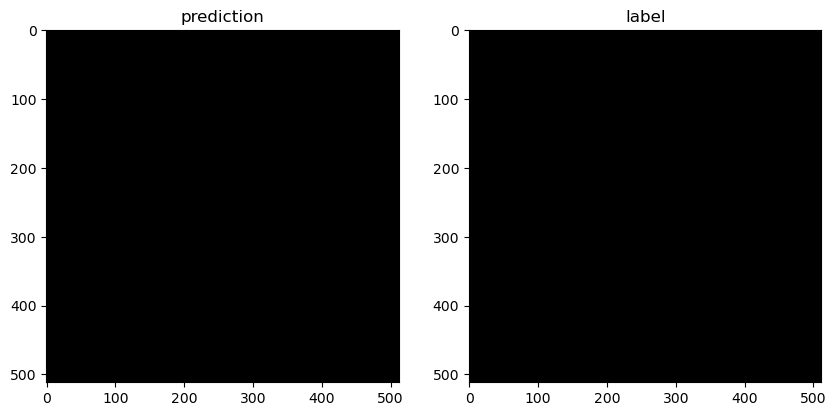

jaccard score 1.0


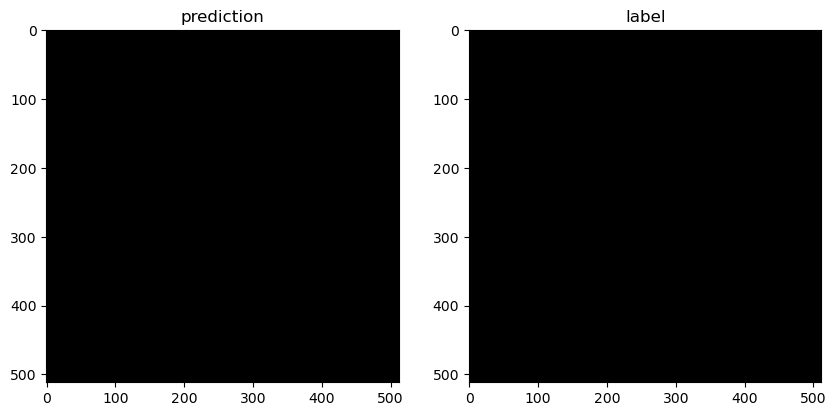

jaccard score 1.0


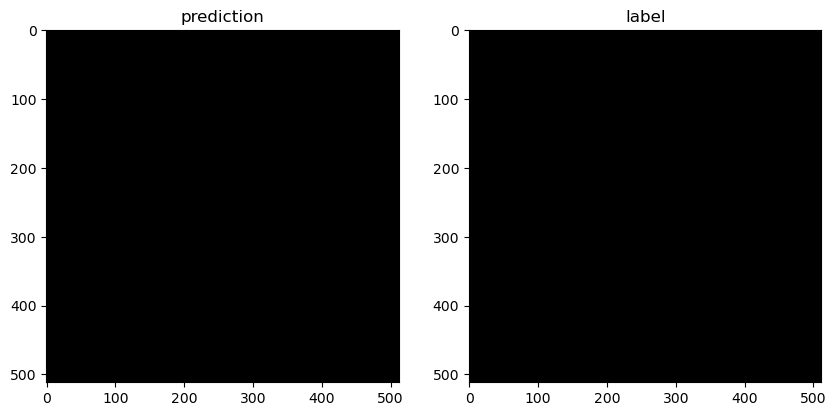

jaccard score 1.0


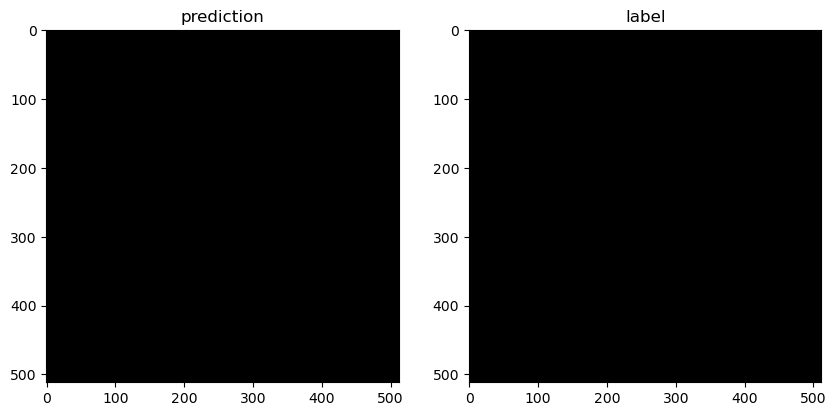

jaccard score 1.0


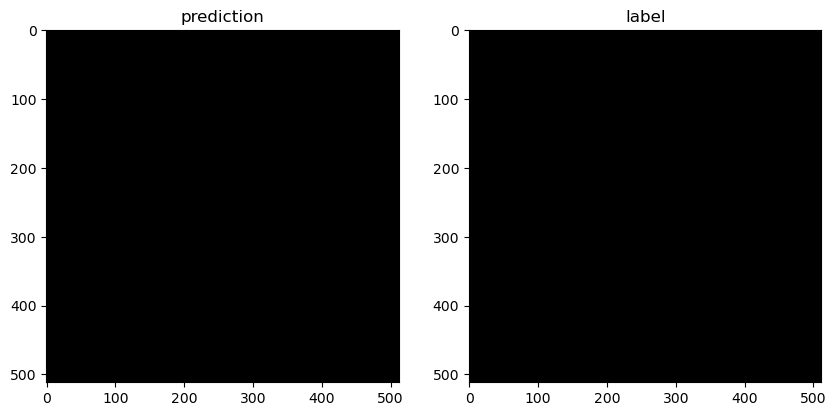

jaccard score 1.0


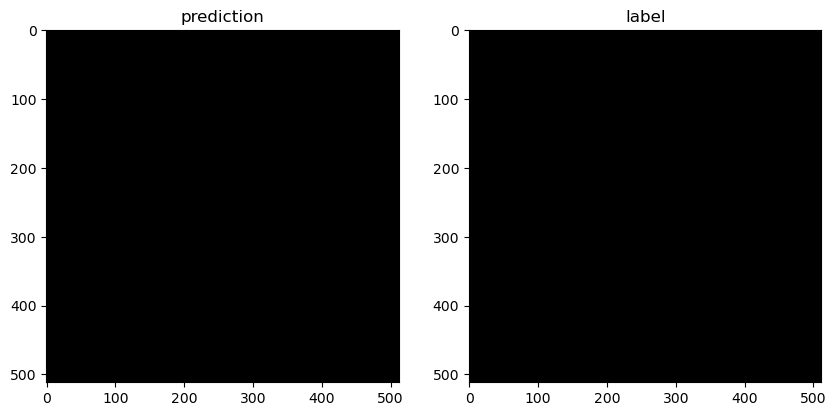

jaccard score 1.0


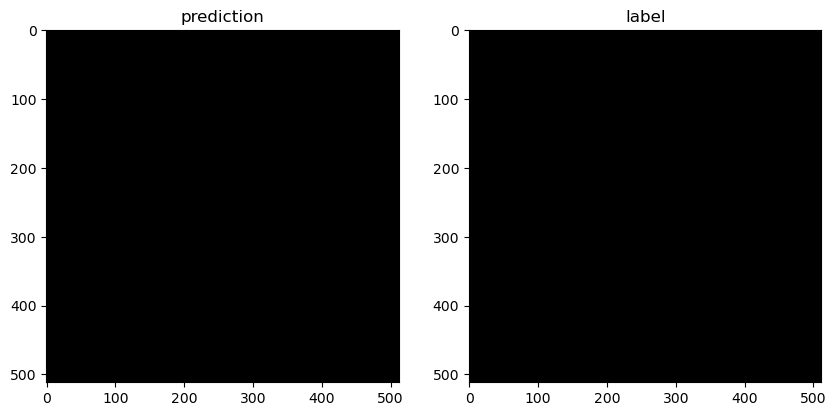

jaccard score 1.0


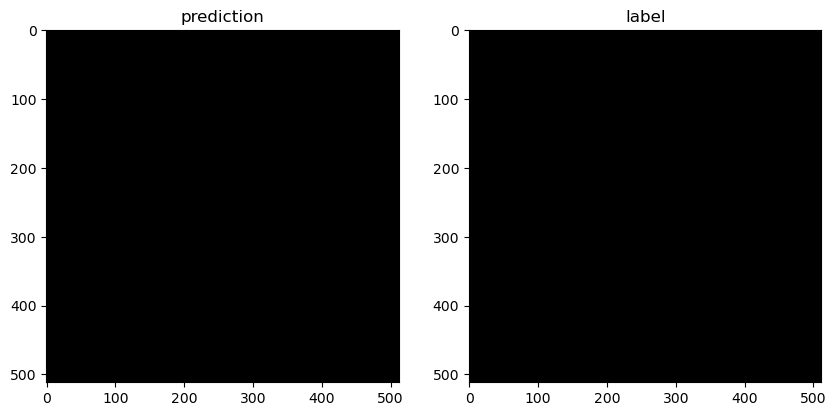

jaccard score 0.9990234375


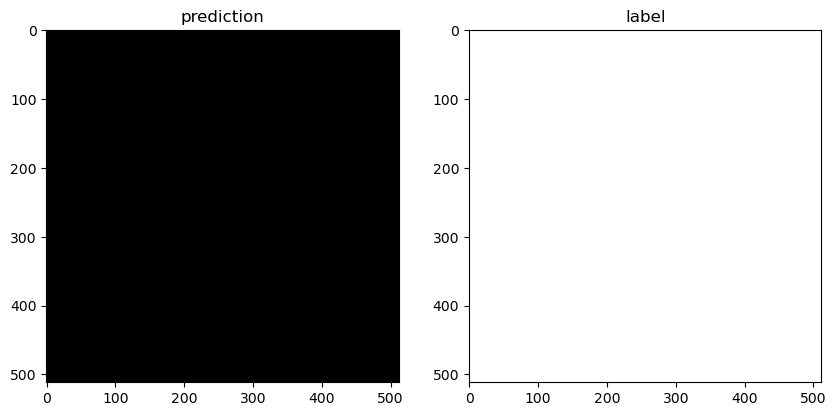

jaccard score 0.9990234375


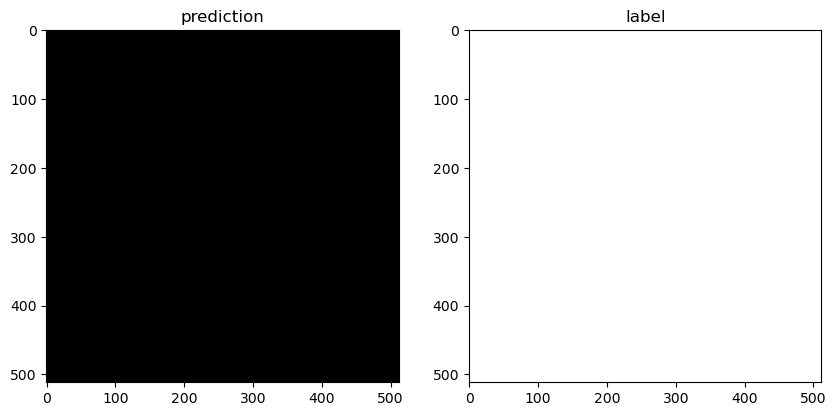

jaccard score 0.9990234375


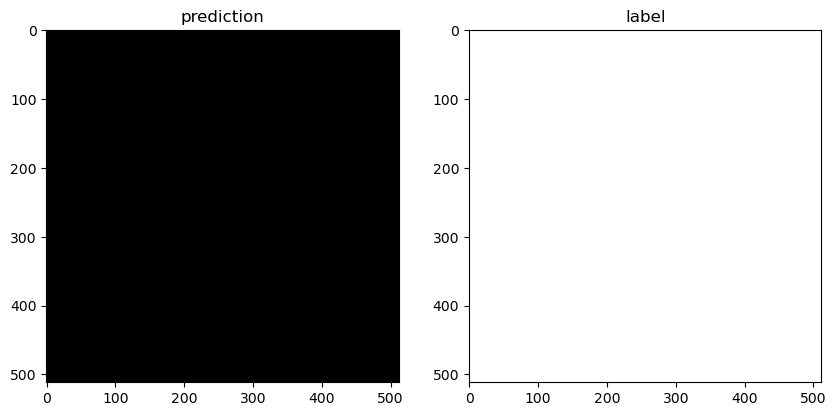

jaccard score 0.9980583190917969


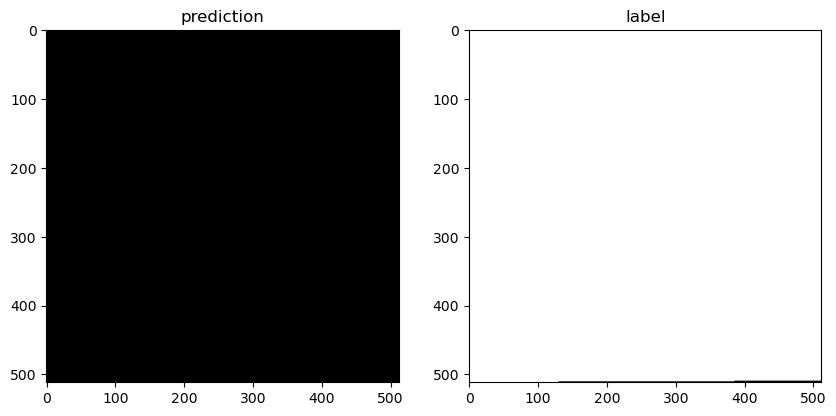

jaccard score 0.9956436638610511


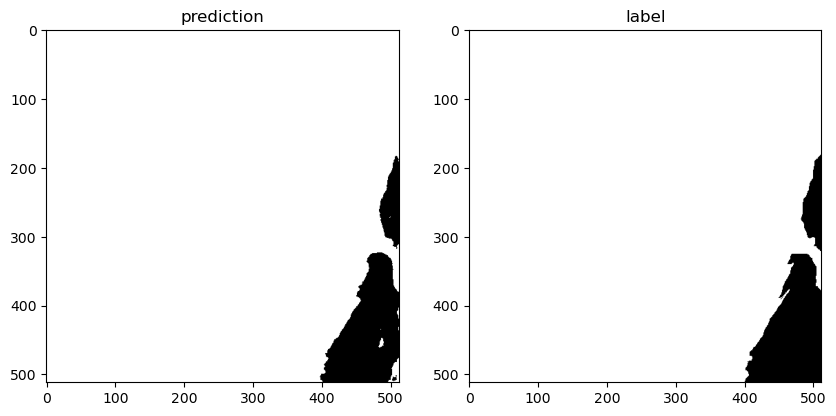

jaccard score 0.9850880282371518


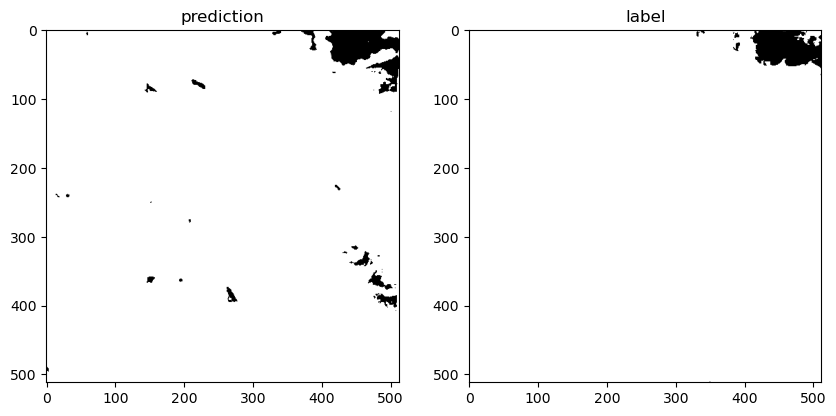

jaccard score 0.9846933075118245


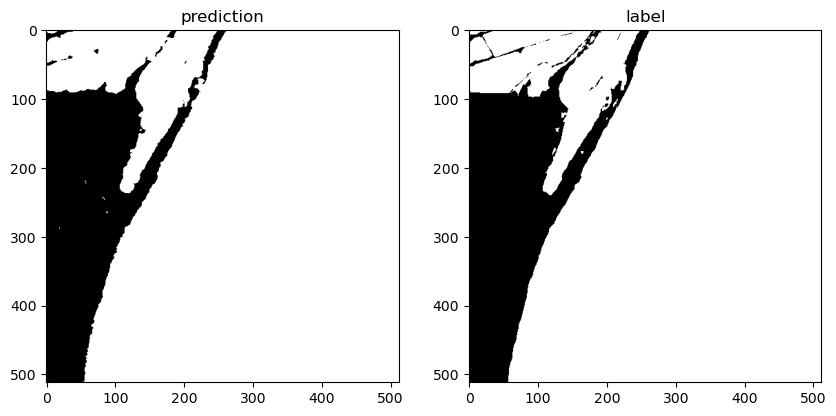

jaccard score 0.9755279120791843


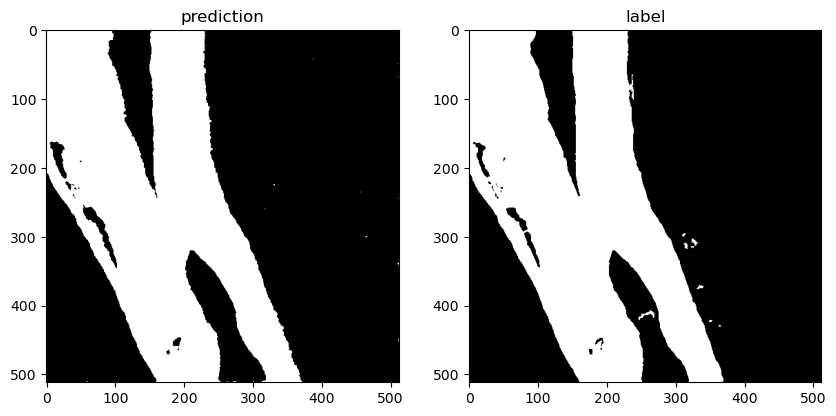

jaccard score 0.9748588385607715


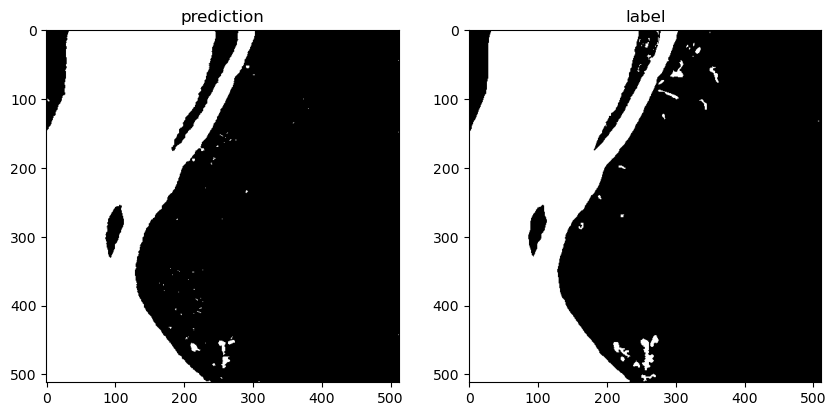

jaccard score 0.9713945172824792


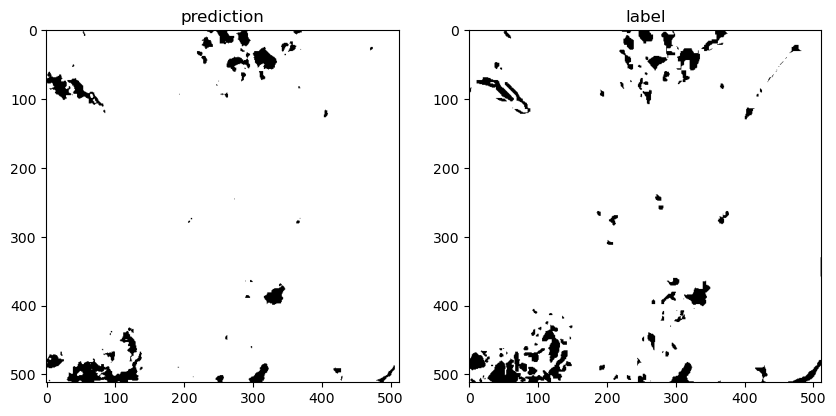

jaccard score 0.9551217038539553


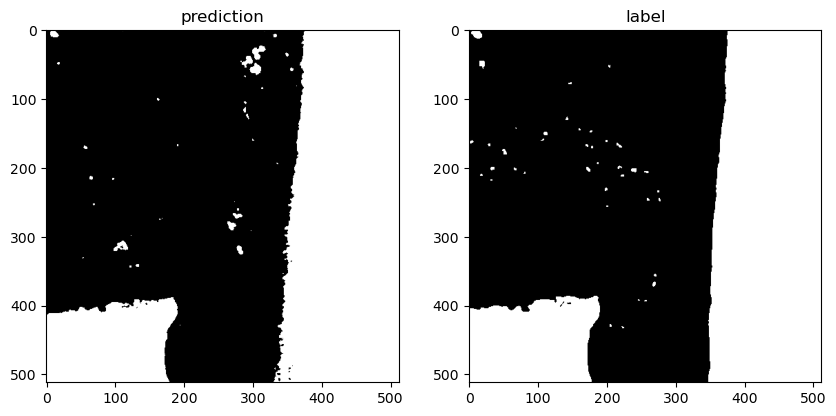

jaccard score 0.9368214502407601


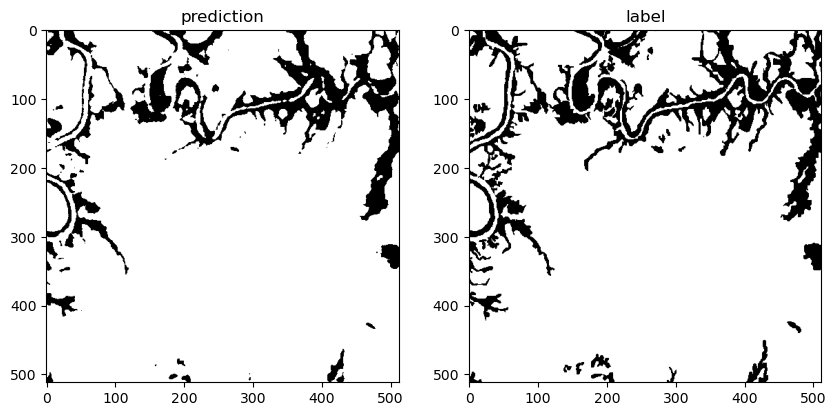

jaccard score 0.9323830922623227


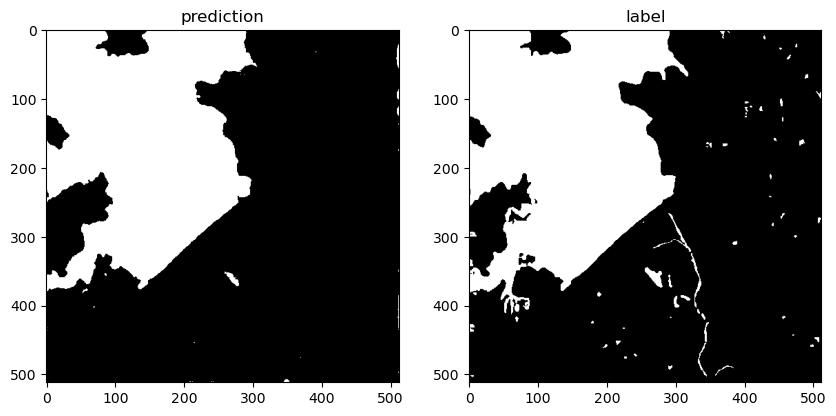

jaccard score 0.9248881123028564


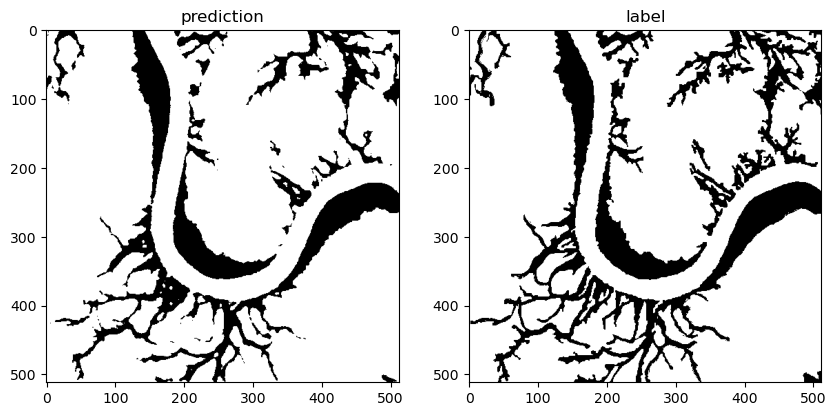

jaccard score 0.921325151021191


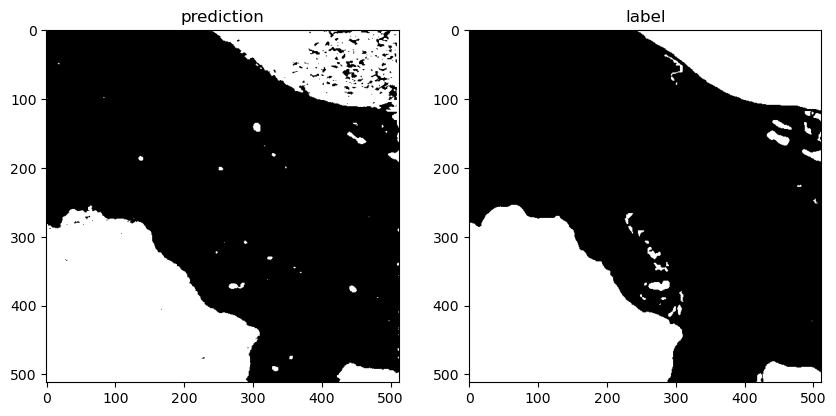

jaccard score 0.9204297536454213


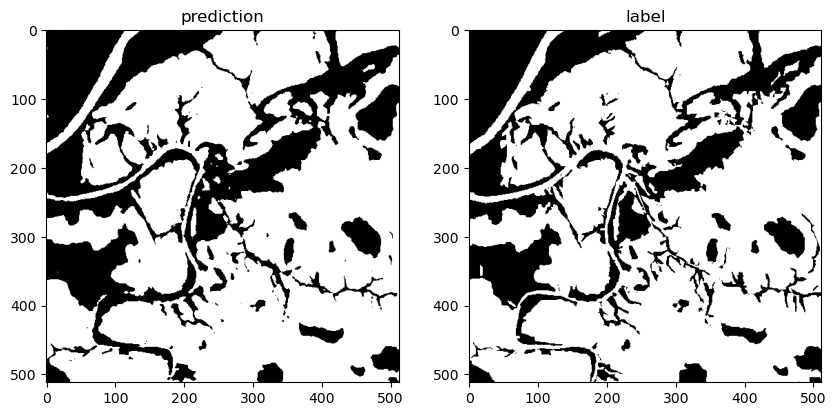

jaccard score 0.9153740764300045


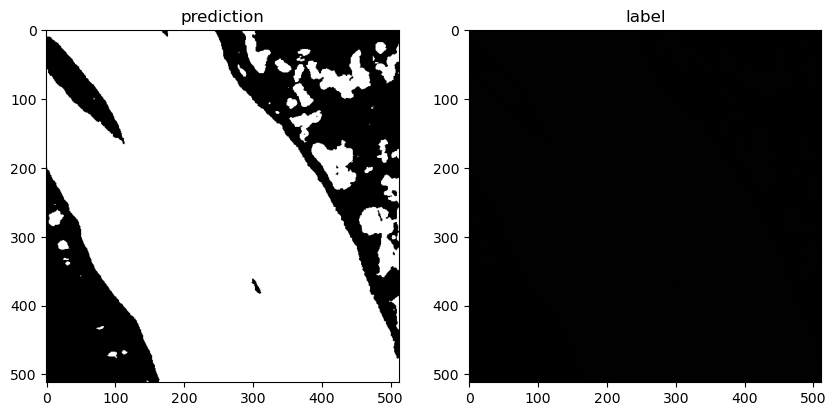

jaccard score 0.9150140224358975


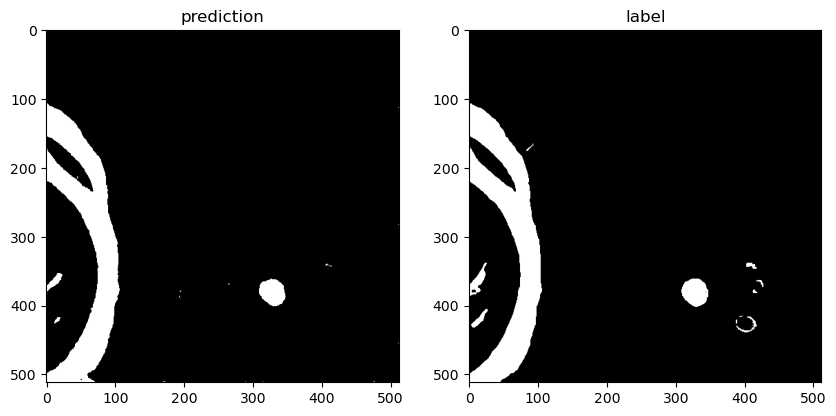

jaccard score 0.9129880392227291


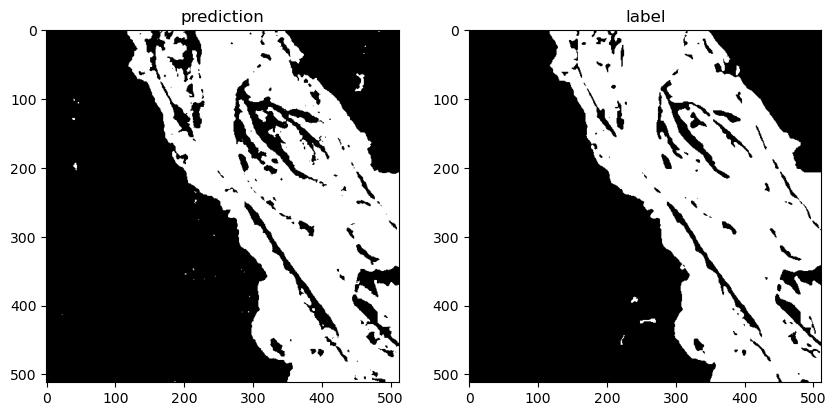

In [77]:
best = df.iloc[0:30].index.to_list()
print(best)
for id_ in best:
    print("jaccard score", result[id_])
    display(train_metadata, id_)